In [0]:
# Source: https://www.tensorflow.org/tutorials/text/nmt_with_attention
 # license: Apache License 2.0

### Libraries along with their versions used at the time of making notebook-
google	2.0.3

matplotlib	3.1.3

numpy	1.18.1

tensorflow	2.1.0

# Neural machine translation with attention

Firstly, let's select TensorFlow version 2.x in colab

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

As we are using google colab, we need to mount the google drive to load the data file

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Add path to the file

In [0]:
path_to_file = '/content/drive/My Drive/NLP/mar.txt'

Let's convert unicode file to ascii

In [0]:
import unicodedata

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

Preprocessing the sentence

In [0]:
import re

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    #w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w) # COMMENT THIS LINE FOR NON-LATIN SCRIPTS SUCH AS MARATHI, HINDI ETC.
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

Now let's define a function to create the dataset

In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, MARATHI]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

Let's create data for 10 examples to visualize

In [0]:
create_dataset(path_to_file, num_examples=10)

[['<start> go . <end>', '<start> जा . <end>'],
 ['<start> run ! <end>', '<start> पळ ! <end>'],
 ['<start> run ! <end>', '<start> धाव ! <end>'],
 ['<start> run ! <end>', '<start> पळा ! <end>'],
 ['<start> run ! <end>', '<start> धावा ! <end>'],
 ['<start> who ? <end>', '<start> कोण ? <end>'],
 ['<start> wow ! <end>', '<start> वाह ! <end>'],
 ['<start> fire ! <end>', '<start> आग ! <end>'],
 ['<start> fire ! <end>', '<start> फायर ! <end>'],
 ['<start> help ! <end>', '<start> वाचवा ! <end>']]

Define a class to create a word -> index mapping

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(mr for en, mr in pairs)
    targ_lang = LanguageIndex(en for en, mr in pairs)
    
    # Vectorize the input and target languages
    
    # Other language sentences
    input_tensor = [[inp_lang.word2idx[s] for s in mr.split(' ')] for en, mr in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, mr in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [0]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [0]:
from sklearn.model_selection import train_test_split

# Creating training and validation sets using an 90-10 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(27000, 27000, 3000, 3000)

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [0]:
import numpy as np

def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [0]:
import os
optimizer = tf.optimizers.Adam()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
import time

EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.1159
Epoch 1 Batch 100 Loss 2.0837
Epoch 1 Batch 200 Loss 1.8180
Epoch 1 Batch 300 Loss 1.7191
Epoch 1 Batch 400 Loss 1.6749
Epoch 1 Loss 1.9314
Time taken for 1 epoch 110.1273205280304 sec

Epoch 2 Batch 0 Loss 1.4851
Epoch 2 Batch 100 Loss 1.4336
Epoch 2 Batch 200 Loss 1.4642
Epoch 2 Batch 300 Loss 1.1762
Epoch 2 Batch 400 Loss 1.1769
Epoch 2 Loss 1.3400
Time taken for 1 epoch 97.06244373321533 sec

Epoch 3 Batch 0 Loss 0.9077
Epoch 3 Batch 100 Loss 1.0279
Epoch 3 Batch 200 Loss 1.0072
Epoch 3 Batch 300 Loss 0.8589
Epoch 3 Batch 400 Loss 0.7926
Epoch 3 Loss 0.9783
Time taken for 1 epoch 96.16630625724792 sec

Epoch 4 Batch 0 Loss 0.6700
Epoch 4 Batch 100 Loss 0.6798
Epoch 4 Batch 200 Loss 0.7611
Epoch 4 Batch 300 Loss 0.6764
Epoch 4 Batch 400 Loss 0.6276
Epoch 4 Loss 0.6723
Time taken for 1 epoch 95.91673493385315 sec

Epoch 5 Batch 0 Loss 0.4551
Epoch 5 Batch 100 Loss 0.4230
Epoch 5 Batch 200 Loss 0.5427
Epoch 5 Batch 300 Loss 0.3663
Epoch 5 Batch 400 Loss 0.4

In [0]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints/ckpt-6'

In [0]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
import matplotlib.pyplot as plt

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    print('Input: {}'.format(sentence))
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' '))-1, :len(sentence.split(' '))-1]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: चांगला कॅमेरा आहे
Input: <start> चागला कमरा आह <end>
Predicted translation: it is a good camera . <end> 


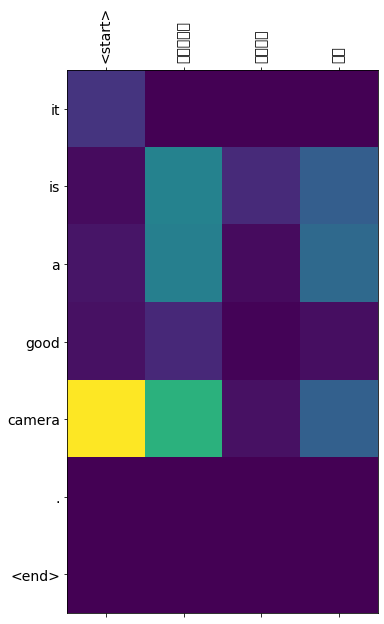

In [0]:
# translate('hace mucho frio aqui.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
# translate('esta es mi vida.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
# translate('trata de averiguarlo.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
translate('चांगला कॅमेरा आहे', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)